## This notebook is for using the MCMC algorithm with idfferent conditions and checking convergence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import main data
data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")
# import systematic error
data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

from core_mcmc_functions import chain

In [2]:
from prior_likelihood import likelihood
from prior_likelihood import prior

def sys_error_likelihood(params, data):
    return likelihood(params, data, sys_error=sys_error_data)

In [5]:
#good parameters= [.52, .82, 74, -19.23]
chn, rej = chain(data_lcparam, 10000, 2000, .001, start_state=[.4, .6, 74, -19.23], variances=None, prior_mode='uniform' )
#chn, rej = chain(data_lcparam, 1000, 200, .01, start_state=[.5, .7, 65, -20], variances=[.01, .01, .25, .1], prior_mode='M prior', likelihood_func= sys_error_likelihood )

total trials:5507. accepted 45.3% of trials


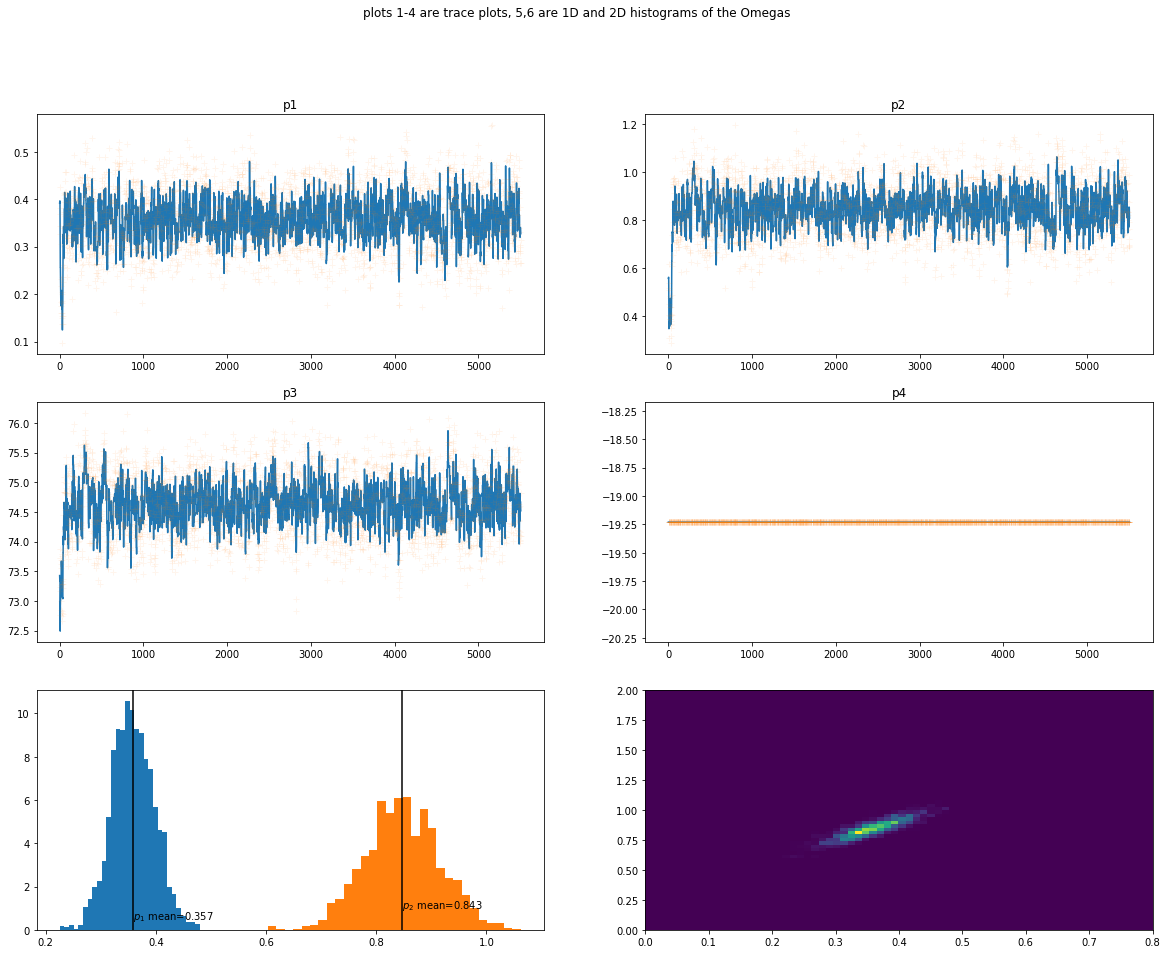

In [6]:
plot_rejects=True
fig,ax = plt.subplots(3,2, figsize=(20,15))
fig.suptitle('plots 1-4 are trace plots, 5,6 are 1D and 2D histograms of the Omegas')

ax[0,0].plot(chn[:,0])
ax[0,0].set_title('p1')
ax[0,1].plot(chn[:,1])
ax[0,1].set_title('p2')
ax[1,0].plot(chn[:,2])
ax[1,0].set_title('p3')
ax[1,1].plot(chn[:,3])
ax[1,1].set_title('p4')
if plot_rejects==True:
    rej_a = 400/len(rej[:,0])
    ax[0,0].plot(rej[:,0], '+', alpha=rej_a)
    ax[0,1].plot(rej[:,1], '+', alpha=rej_a)
    ax[1,0].plot(rej[:,2], '+', alpha=rej_a)
    ax[1,1].plot(rej[:,3], '+', alpha=rej_a)
cutoff=int(len(chn[:,0])/5)
cchn=chn[cutoff:,:]    
ax[2,0].hist(cchn[:,0],bins=30, density=1);
ax[2,0].axvline(np.mean(cchn[:,0]), color='k')
ax[2,0].text(np.mean(cchn[:,0]),.5,'$p_1$ mean={:.3f}'.format(np.mean(chn[:,0])))
ax[2,0].axvline(np.mean(cchn[:,1]), color='k') 
ax[2,0].text(np.mean(cchn[:,1]),1,'$p_2$ mean={:.3f}'.format(np.mean(chn[:,1])))
ax[2,0].hist(cchn[:,1],bins=30, density=1);

#ax[2,1].hist2d(cchn[:,0],cchn[:,1], bins=70, range=[[0, .8], [0, 2]]);
ax[2,1].hist2d(cchn[:,0],cchn[:,1], bins=70, range=[[0, .8], [0, 2]]);
#ax[2,1].scatter(cchn[:,0],cchn[:,1], alpha=.01);

In [9]:
def likelihood_test(resolution, p1_min, p1_max, p2_min, p2_max, p1_slice=.52, p2_slice=.82, two_d=True, data=data_lcparam):
    p1= np.linspace(p1_min,p1_max,resolution)
    p2= np.linspace(p2_min,p2_max,resolution)
    p1_lik=np.zeros(resolution)
    p2_lik=np.zeros(resolution)

    for i, p1_item in enumerate(p1):
            p1_lik[i]= likelihood([p1_item,p2_slice,74,-19.23], data)
    for j,p2_item in enumerate(p2):
        p2_lik[j] = likelihood([p1_slice,p2_item,74,-19.23], data)
            
    fig, ax =plt.subplots(2, figsize=(5,8))
    ax[0].plot(p1,p1_lik)
    ax[0].set_title('log likelihood of p1 when p2={}'.format(p2_slice))
    ax[1].plot(p2,p2_lik)
    ax[1].set_title('log likelihood of p2 when p1={}'.format(p1_slice))
    
    if two_d:
        x, y = np.meshgrid(p1,p2)
        likelihood_array=np.zeros((resolution,resolution))
        for i, p1_item in enumerate(p1):
            for j,p2_item in enumerate(p2):
                likelihood_array[i,j]= likelihood([p1_item,p2_item,74,-19.23], data)
    return(x, y, likelihood_array)


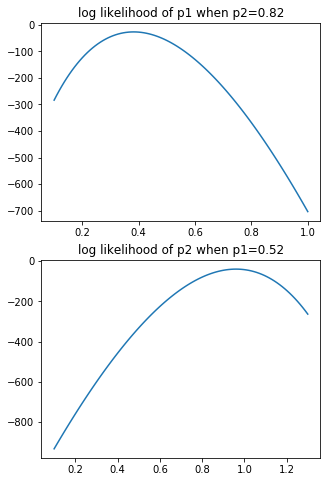

In [10]:
x, y, z = likelihood_test(100,.1,1,0.1, 1.3)

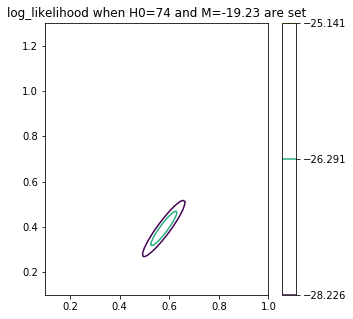

In [11]:
fig, ax = plt.subplots(1, figsize=(5,5))
c1 = np.max(z)- 2.3/2
c2 = np.max(z)- 6.17/2
contours=[c2, c1, np.max(z)]
c = ax.contour(x, y, z, contours)
fig.colorbar(c, ax=ax)
ax.set_title('log_likelihood when H0=74 and M=-19.23 are set');

these cells are for calculating the covariance matrix for better convergence

In [16]:
cov=np.cov(cchn, y=None, rowvar=False)
cov=cov/np.max(np.abs(cov))

In [4]:
cov=np.array([[ 3.42075953e-01,  1.68095588e-01, -2.97425759e-01,
        0],
       [ 1.68095588e-01,  8.31391081e-02, -1.48100068e-01,
        0],
       [-2.97425759e-01, -1.48100068e-01,  1.00000000e+00,
         0],
       [0,0,0,0]])
